In [1]:
## imports
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import xarray as xr
import geopandas as gpd
from shapely.geometry import box
import glob
import datetime
import pandas as pd

In [2]:
# 0 WRF coords
from fos.data import huc6
from fos.data import snotel_no_ak
wrfdir = '/glade/campaign/uwyo/wyom0112/postprocess/'
coorddir = wrfdir + 'meta/meta_new/' 
coords = xr.open_dataset(coorddir + 'wrfinput_d02')
lon_2d = coords.XLONG[0,:,:]
lat_2d = coords.XLAT[0,:,:]


In [ ]:
## all-domain MLR . S1-824 in the predictor fields, all grid in the outcome field.
## do one with topo and one without topo. should have lat and lon in there too... 

In [4]:
##1 define model
ncfg = 1
config = {'where': ['basin'],
          'when': ['April 1'],
          'forcing' : ['snow', 't2max'],
          'static' : [],
          'train': ['hist'],
          'model': ['linreg'],
          'gcm' : ['access-cm2_r5i1p1f1'],
          'bc' : [True],
          'domain':['d02'],
          'basin_shp': huc6
}

In [3]:
## snotel info
lat_indices = []
lon_indices = []
diffs = []
snotel_lons = np.array(snotel_no_ak.geometry.x.values)
snotel_lats = np.array(snotel_no_ak.geometry.y.values)
for i in range(824):
    target_lon = snotel_lons[i]
    target_lat = snotel_lats[i]
    # Calculate the geometric distance between each grid point and the target coordinate
    distances = np.sqrt((lat_2d.data - target_lat)**2 + (lon_2d.data - target_lon)**2)
    
    # Find the index of the minimum distance value
    min_index = np.where(distances == np.nanmin(distances))
    
    # Append the latitude and longitude indices to their respective lists
    lat_indices.append(min_index[0])
    lon_indices.append(min_index[1])
    diffs.append(np.nanmin(distances))

    
for i in range(ncfg):
    where = config['where'][i]
    when = config['when'][i]
    forcing = config['forcing']
    # static = config['static'][i]
    train = config['train'][i]
    model = config['model'][i]
    gcm = config['gcm'][i]
    bc = config['bc'][i]
    domain = config['domain'][i]
    files = []
    if bc:
        for val in forcing:
            files += glob.glob(wrfdir + f'{gcm}_*_bc/postprocess/{domain}/{val}*') 
    else:
        files = glob.glob(wrfdir + f'{gcm}_*_bc/postprocess/{domain}/*')
        
all_data = xr.open_mfdataset(files, combine='by_coords')
all_data = all_data.assign_coords(lat2dind = all_data.lat2d)
all_data = all_data.assign_coords(lon2dind = all_data.lon2d)
print(f'loaded data for variables {[var for var in all_data.variables]} from {all_data.day[0].data.tolist()} to  {all_data.day[-1].data.tolist()}')

NameError: name 'ncfg' is not defined

In [430]:
import xarray as xr
import pandas as pd

def count_days_below_threshold(da, threshold=5):
    return (da < threshold).sum(dim='day')

# Load the dataset (replace with your dataset file)
ds = all_data.copy()
# Parse the date index to the appropriate format
ds['day'] = pd.to_datetime(ds['day'].values, format='%Y%m%d')

# Calculate the number of days with snow values below 5 for each water year
water_year_starts = pd.date_range(ds['day'].values[0], ds['day'].values[-1], freq='AS-OCT')
result_list = []

for start_date in water_year_starts:
    end_date = start_date + pd.DateOffset(years=1) - pd.DateOffset(days=1)
    
    if end_date > ds['day'].values[-1]:
        break

    # Select data within the water year
    ds_water_year = ds.sel(day=slice(start_date, end_date))
    
    # Calculate the number of days with snow values below 5 for each pixel
    result = ds_water_year['snow'].groupby('day.year').map(count_days_below_threshold)
    result_list.append(result)

result_da = xr.concat(result_list, dim='year')
result_ds = result_da.to_dataset(name='days_below_threshold')

print(result_ds)


<xarray.Dataset>
Dimensions:               (lat2d: 340, lon2d: 270, year: 238)
Coordinates:
    lat2dind              (lat2d) int64 0 1 2 3 4 5 ... 334 335 336 337 338 339
    lon2dind              (lon2d) int64 0 1 2 3 4 5 ... 264 265 266 267 268 269
  * year                  (year) int64 1980 1981 1981 1982 ... 2098 2098 2099
Dimensions without coordinates: lat2d, lon2d
Data variables:
    days_below_threshold  (year, lat2d, lon2d) int64 dask.array<chunksize=(1, 340, 270), meta=np.ndarray>


In [ ]:
import cartopy.crs as ccrs

# Plot the results
fig, axes = plt.subplots(nrows=len(result_list), figsize=(10, 60), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = plt.get_cmap('viridis')

for i, (ax, year_da) in enumerate(zip(axes, result_list)):
    year_da.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=365)
    ax.set_title(f'Water Year: {water_year_starts.year[i]}-{(water_year_starts.year[i] + 1)}')
    ax.coastlines()

plt.tight_layout()
plt.show()

In [ ]:
## group results by elevation bin

elevation_ds = coords
# Define elevation bins
elevation_bins = np.arange(0, 15000, 500)  # 
# Calculate the average number of days below the threshold for each elevation bin
elevation_labels = (elevation_bins[:-1] + elevation_bins[1:]) / 2
result_ds['elevation'] = elevation_ds['HGT']
result_ds['elevation_bins'] = xr.DataArray(pd.cut(result_ds.elevation.values.flatten(), elevation_bins, labels=elevation_labels).astype(float).reshape(result_ds.elevation.shape), dims=result_ds.elevation.dims, coords=result_ds.elevation.coords)

average_days_by_elevation = result_ds.groupby('elevation_bins').mean(dim=['lat2d', 'lon2d'])

# Plot the time series data
fig, ax = plt.subplots(figsize=(10, 5))

for elevation in average_days_by_elevation.elevation_bins.values:
    ax.plot(water_year_starts.year[:-1], average_days_by_elevation['days_below_threshold'].sel(average_days_by_elevation['elevation_bins']==elevation), label=f'{elevation} m')

ax.set_xlabel('Water Year')
ax.set_ylabel('Average Number of Days Below Threshold')
ax.set_title('Time Series of Average Number of Days with Snow Below Threshold by Elevation')
ax.legend(title='Elevation', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [452]:
plotme = average_days_by_elevation.groupby('elevation_bins').mean('stacked_Time_south_north_west_east')

In [ ]:
fig,ax=plt.subplots()
for i in range(8):
    ax.plot(plotme.days_below_threshold[i,:])
plt.show()

In [438]:
result_ds

<xarray.Dataset>
Dimensions:               (lat2d: 340, lon2d: 270, year: 238, Time: 1,
                           south_north: 340, west_east: 270)
Coordinates:
    lat2dind              (lat2d) int64 0 1 2 3 4 5 ... 334 335 336 337 338 339
    lon2dind              (lon2d) int64 0 1 2 3 4 5 ... 264 265 266 267 268 269
  * year                  (year) int64 1980 1981 1981 1982 ... 2098 2098 2099
    XLAT                  (Time, south_north, west_east) float32 22.27 ... 57.58
    XLONG                 (Time, south_north, west_east) float32 -116.7 ... -...
Dimensions without coordinates: lat2d, lon2d, Time, south_north, west_east
Data variables:
    days_below_threshold  (year, lat2d, lon2d) int64 dask.array<chunksize=(1, 340, 270), meta=np.ndarray>
    elevation             (Time, south_north, west_east) float32 0.0 ... 398.6
    elevation_bins        (Time, south_north, west_east) float64 nan ... 250.0

In [116]:
april1data = all_data.where(all_data['day'].astype(str).str.contains('\d{4}0401', regex=True), drop=True)
da = april1data['snow']

In [194]:
## params
y1 = 0
y2 = -1
x1 = 0
x2 = -1
t1 = 0
t2 = 120
##
testdata = da[t1:t2,y1:y2,x1:x2].values
basinmask = np.zeros((340,270))
basinmask[y1:y2, x1:x2] = 1
basinmask = basinmask > 0
testmask = np.zeros(testdata.shape[1:])
testmask = testmask == 0


In [ ]:
y1 = 0
y2 = 300
x1 = 0
x2 = -1
t1 = 0
t2 = 120
mask = (lat_2d < 50) & (lat_2d > 32) & (lon_2d < -100) & (lon_2d > -124) & (np.nansum(da, axis = 0) > 1)
mask_broadcasted = np.broadcast_to(mask, da.shape)
lonmask = np.ma.masked_array(lon_2d, mask=~mask)
latmask = np.ma.masked_array(lat_2d, mask=~mask)
testmask = np.zeros(testdata.shape[1:])
testmask = testmask == 0
testdata = da[0:1].values
masked = np.ma.masked_array(da[t1:t2], mask=~mask_broadcasted)
#plt.pcolormesh(lon_2d[latmask],lat_2d[latmask], testdata)

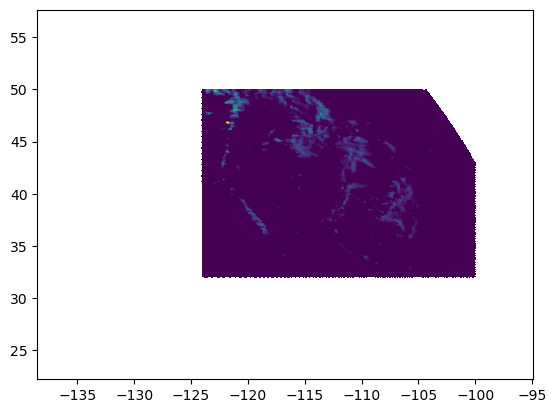

In [233]:
plt.pcolormesh(lon_2d, lat_2d, masked[0])

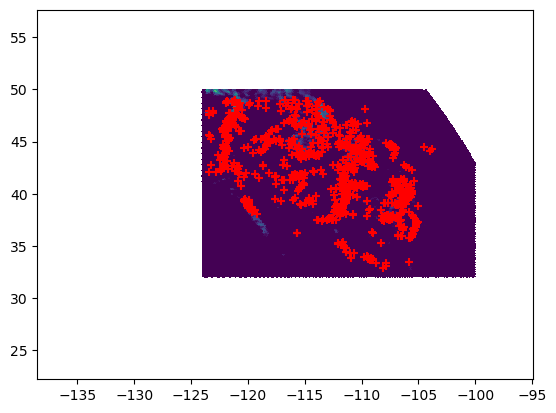

In [238]:
## if you change the geog bounds, need to do this again, also showss locations of snotels on the map
#plt.pcolormesh(lon_2d[y1:y2,x1:x2],lat_2d[y1:y2,x1:x2], testdata[0])
plt.pcolormesh(lon_2d, lat_2d, masked[0])
sparsedata = []
sparseidx=[]
for i in range(824):
    isin = (basinmask[lat_indices[i], lon_indices[i]])
    locmask = np.zeros((340,270))
    locmask[lat_indices[i], lon_indices[i]] = 1
    if np.nansum(locmask[basinmask]) > 0:
        isin2 = True
    else:
        isin2 = False
    if isin2:
        idx = np.where(locmask[basinmask] > 0)
        sparsedata.append(masked[:,testmask][:,idx].flatten())
        sparseidx.append(idx[0][0])
        plt.scatter(lon_2d[lat_indices[i], lon_indices[i]], lat_2d[lat_indices[i], lon_indices[i]], marker = '+', color = 'red')

In [239]:
## prep X and y matrices for learning
snotel_data = np.array(sparsedata).transpose()
print(snotel_data.shape)
gridded_data = np.array(masked).reshape(t2-t1,-1)
print(gridded_data.shape)
X = np.concatenate([snotel_data, gridded_data],axis=1)
df = pd.DataFrame(X)

(120, 824)
(120, 91800)


In [246]:
plt.hist(gridded_data)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2b9288b065f0> (for post_execute):



KeyboardInterrupt



In [241]:
import pandas as pd
from sklearn.linear_model import LinearRegression

N_snotel = len(sparsedata)

# Split the data into predictors (X) and target variable (y)
X = df.iloc[:, :N_snotel].values  # assume each predictor has multiple years of data
y = df.iloc[:, N_snotel:].values  # assume the outcome has multiple years of data

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Train the model
reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean squared error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean squared error: 1672.14
R-squared: -22376727.36


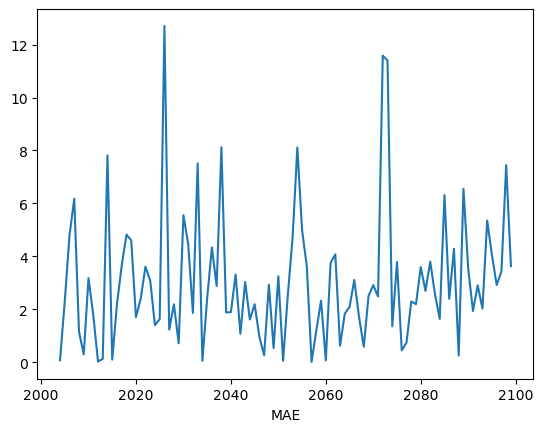

In [243]:
fig,ax = plt.subplots()
# ax.plot(range(1980,1980+len(X_train)), np.nanmean(y_pred_train - y_train,axis=1) )
ax.plot(range(1980+len(X_train),1980+len(X_train) + len(X_test)),np.abs(np.nanmean(y_pred - y_test,axis=1)))
ax.set_xlabel('MAE')
plt.show()

In [308]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

snotel_data_df = pd.DataFrame(snotel_data)
gridded_data_df = pd.DataFrame(gridded_data)

# Calculate correlation for each year
def get_annual_correlations(gridded_data, snotel_data, years):
    correlations = []

    for year in years:
        # Filter data for the current year
        gridded_year_data = gridded_data[gridded_data.index == year]
        #gridded_year_data.drop('year')
        snotel_year_data = snotel_data[snotel_data.index == year]
        #snotel_year_data.drop('year')

        # Calculate correlation between SNOTEL station values and gridded values
        corr, _ = pearsonr(gridded_year_data.values, snotel_year_data.values)
        correlations.append((year, corr))
        #except:
         #   print(year)

    return correlations


In [329]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

snotel_data_df = pd.DataFrame(snotel_data)
gridded_data_df = pd.DataFrame(gridded_data)
years = range(1980, 2100)
snotel_data_df.index= years
gridded_data_df.index= years

# Calculate correlation for each year
correlations = []

for year in [1981]:
    # Filter data for the current year
    gridded_year_data = gridded_data_df[gridded_data_df.index == year]
    #gridded_year_data.drop('year')
    snotel_year_data = snotel_data_df[snotel_data_df.index == year]
    #snotel_year_data.drop('year')

In [350]:
y = gridded_year_data.values
X = snotel_year_data.values
mlr = LinearRegression()
mlr.fit(X, y)
y_pred = mlr.predict(X)
mse = mean_squared_error(y.transpose(), y_pred.transpose())
r2 = r2_score(y.transpose(), y_pred.transpose())


In [361]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load datasets (replace with your data files)
#gridded_values = pd.read_csv('gridded_values.csv')
#snotel_values = pd.read_csv('snotel_values.csv')

# Train and evaluate an MLR model for each year
def get_annual_mlr_models(gridded_data, snotel_data, years):
    mlr_models = []
    evaluation_results = []

    for year in years:
        # Filter data for the current year
        gridded_year_data = gridded_data[gridded_data.index == year]
        snotel_year_data = snotel_data[snotel_data.index == year]

        # Train an MLR model
        X = snotel_year_data.values
        y = gridded_year_data.values
        mlr = LinearRegression()
        mlr.fit(X, y)

        # Evaluate the MLR model
        y_pred = mlr.predict(X)
        mse = mean_squared_error(y.transpose(), y_pred.transpose())
        r2 = r2_score(y.transpose(), y_pred.transpose())

        mlr_models.append(mlr)
        evaluation_results.append((year, mse, r2))

    return mlr_models, evaluation_results

# Replace with the range of years in your dataset
years = range(1980, 2100)
mlr_models, evaluation_results = get_annual_mlr_models(gridded_data_df, snotel_data_df, years)

# Analyze evaluation results
evaluation_df = pd.DataFrame(evaluation_results, columns=['year', 'mse', 'r2_score'])
print(evaluation_df)


     year  mse  r2_score
0    1980  0.0       1.0
1    1981  0.0       1.0
2    1982  0.0       1.0
3    1983  0.0       1.0
4    1984  0.0       1.0
..    ...  ...       ...
115  2095  0.0       1.0
116  2096  0.0       1.0
117  2097  0.0       1.0
118  2098  0.0       1.0
119  2099  0.0       1.0

[120 rows x 3 columns]


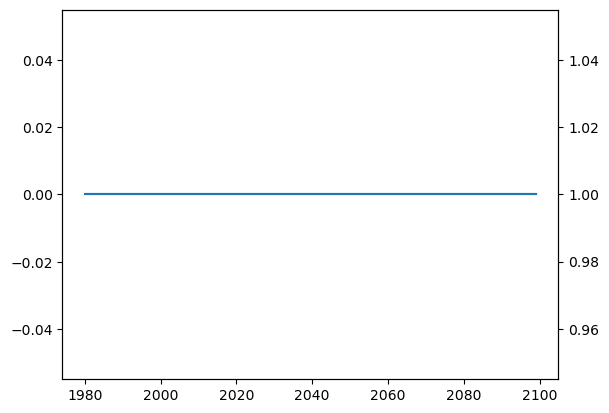

In [362]:
fig,ax = plt.subplots()
ax.plot(evaluation_df.year, evaluation_df.mse)
ax2 = ax.twinx()
ax2.plot(evaluation_df.year, evaluation_df.r2_score)
plt.show()

In [309]:

# Replace with the range of years in your dataset
years = np.unique(snotel_data_df.index) 
correlations = get_annual_correlations(gridded_data_df, snotel_data_df, years)

# Analyze correlations over time
correlations_df = pd.DataFrame(correlations, columns=['year', 'correlation'])
correlations_df.plot(x='year', y='correlation', title='Correlation between SNOTEL stations and gridded values over time')


ValueError: x and y must have length at least 2.

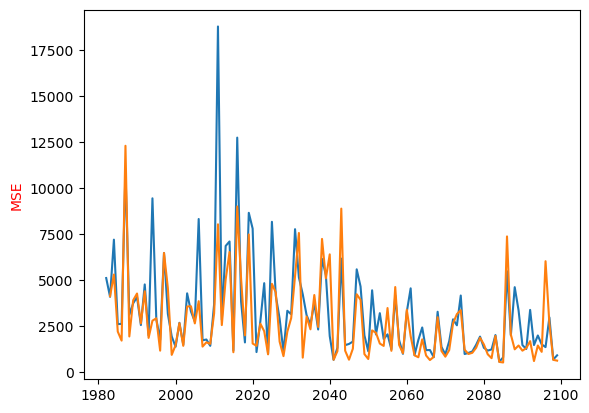

In [370]:

# Train an MLR model for each year using the previous 5 years of data
def get_mlr_models(gridded_data, snotel_data, years, N):
    mlr_models = []
    evaluation_results = []

    for i, year in enumerate(years):
        if i < N:
            continue

        # Filter data for the previous 5 years
        gridded_train_data = gridded_data[gridded_data.index.isin(years[i-N:i])]
        snotel_train_data = snotel_data[snotel_data.index.isin(years[i-N:i])]

        # Train an MLR model
        X_train = snotel_train_data.values
        y_train = gridded_train_data.values
        mlr = LinearRegression()
        mlr.fit(X_train, y_train)

        # Evaluate the MLR model on the 6th year
        gridded_test_data = gridded_data[gridded_data.index== year]
        snotel_test_data = snotel_data[snotel_data.index == year]

        X_test = snotel_test_data.values
        y_test = gridded_test_data.values

        y_pred = mlr.predict(X_test)
        mse = mean_squared_error(y_test.transpose(), y_pred.transpose())
        r2 = r2_score(y_test.transpose(), y_pred.transpose())

        mlr_models.append(mlr)
        evaluation_results.append((year, mse, r2))

    return mlr_models, evaluation_results

# Replace with the range of years in your dataset
years = range(1980, 2100)
results = []
for N in range(2,30):
    mlr_models, evaluation_results = get_mlr_models(gridded_data_df, snotel_data_df, years, N)
    results.append(evaluation_results)

fig,ax = plt.subplots()
# Analyze evaluation results
for i,res in enumerate(results):
    evaluation_df = pd.DataFrame(res, columns=['year', 'mse', 'r2_score'])
    ax.plot(evaluation_df.year, evaluation_df.mse, label = i+2)

ax.set_ylabel('MSE', color = 'red')
plt.show()
    
# print(evaluation_df)


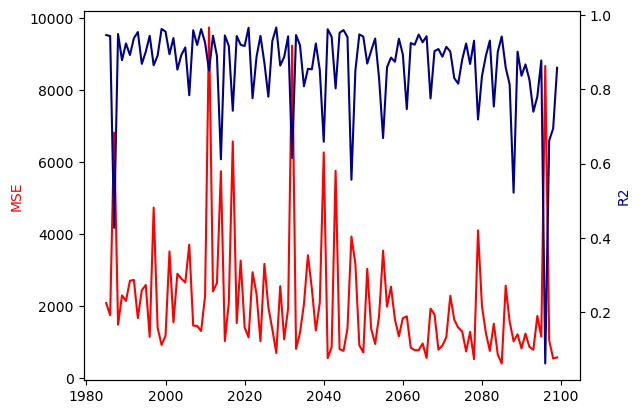

In [369]:
ax.plot(evaluation_df.year, evaluation_df.mse, color = 'red')
ax.set_ylabel('MSE', color = 'red')
ax2 = ax.twinx()
ax2.plot(evaluation_df.year, evaluation_df.r2_score, color = 'darkblue')
ax2.set_ylabel('R2', color = 'darkblue')
plt.show()

In [418]:
## 2 load data
from fos.data import huc6
from fos.data import snotel_no_ak
wrfdir = '/glade/campaign/uwyo/wyom0112/postprocess/'
coorddir = wrfdir + 'meta/meta_new/' 
coords = xr.open_dataset(coorddir + 'wrfinput_d02')
lon_2d = coords.XLONG[0,:,:]
lat_2d = coords.XLAT[0,:,:]

# Create a Polygon object from the bounding box of the lat and lon files
xarray_bbox = (min(lon_2d.data.flatten()), min(lat_2d.data.flatten()), max(lon_2d.data.flatten()), max(lat_2d.data.flatten()))  # Replace with the bounding box of your xarray
bbox_polygon = box(xarray_bbox[0], xarray_bbox[1], xarray_bbox[2], xarray_bbox[3])

huc6_wrf = huc6[huc6.geometry.intersects(bbox_polygon)]

shapefile = huc6_wrf[huc6_wrf.name == 'Gunnison']
from shapely import Point 
lat_wrf = lat_2d.data
lon_wrf = lon_2d.data
def get_wrf_from_shp(basin, lat_wrf, lon_wrf, data_wrf):
    bounds = basin.bounds.values.flatten()
    latmask = ((lat_wrf.data >bounds[1]) & (lat_wrf.data < bounds[3]))
    lonmask = ((lon_wrf.data >bounds[0]) & (lon_wrf.data < bounds[2]))
    basinmask = (latmask & lonmask)
    pts = list(map(Point,  zip(lon_wrf[basinmask], lat_wrf[basinmask])))
    polygon = basin[0:1].geometry.values[0]
    inmask = list(map(polygon.contains,  pts))
    inmask = np.array(inmask)
    tmpdata = data_wrf[:,basinmask]  ## this takes forever because it's daily data... possible to make it faster, or at least not split based on this?
    tmpdata[:,~inmask] = np.nan
    return lon_wrf[basinmask], lat_wrf[basinmask], tmpdata

def get_masks_from_shp(basin, lat_wrf, lon_wrf):
    bounds = basin.bounds.values.flatten()
    latmask = ((lat_wrf.data >bounds[1]) & (lat_wrf.data < bounds[3]))
    lonmask = ((lon_wrf.data >bounds[0]) & (lon_wrf.data < bounds[2]))
    basinmask = (latmask & lonmask)
    pts = list(map(Point,  zip(lon_wrf[basinmask], lat_wrf[basinmask])))
    polygon = basin[0:1].geometry.values[0]
    inmask = list(map(polygon.contains,  pts))
    inmask = np.array(inmask)
    return basinmask, inmask



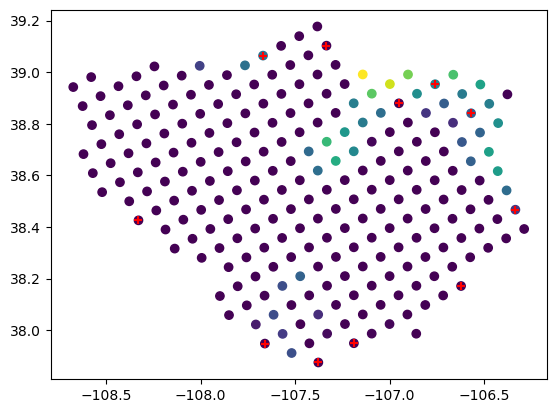

In [389]:

## get wrf snow data
basin = shapefile 

basinmask_gunn, inmask_gunn = get_masks_from_shp(basin, lat_2d.data, lon_2d.data)

lon, lat, basin_data = get_wrf_from_shp(shapefile, lat_2d.data, lon_2d.data, april1data['snow'].values)
## 

#get only the points with snotel stations within the basin
plt.scatter(lon,  lat, c= basin_data[100,:])
sparsedata = []
sparseidx=[]
for i in range(824):
    isin = (basinmask[lat_indices[i], lon_indices[i]])
    locmask = np.zeros((340,270))
    locmask[lat_indices[i], lon_indices[i]] = 1
    if np.nansum(locmask[basinmask_gunn][inmask_gunn]) > 0:
        isin2 = True
    else:
        isin2 = False
    if isin2:
        idx = np.where(locmask[basinmask_gunn][inmask_gunn] > 0)
        sparsedata.append(basin_data[:,idx].flatten())
        sparseidx.append(idx[0][0])
        plt.scatter(lon_2d[lat_indices[i], lon_indices[i]], lat_2d[lat_indices[i], lon_indices[i]], marker = '+', color = 'red')



(120, 11)
(120, 414)


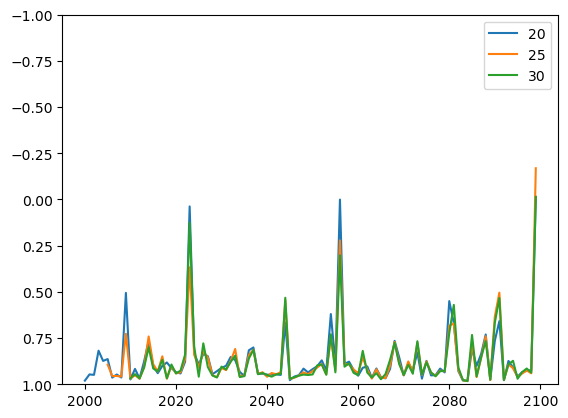

In [413]:
## prep X and y matrices for learning
snotel_data = np.array(sparsedata).transpose()
print(snotel_data.shape)
gridded_data = np.array(basin_data).reshape(basin_data.shape[0],-1)
print(gridded_data.shape)
X = np.concatenate([snotel_data, gridded_data],axis=1)
df = pd.DataFrame(X)

snotel_data_df = pd.DataFrame(snotel_data)
gridded_data_df = pd.DataFrame(gridded_data)
years = range(1980, 2100)
snotel_data_df.index= years
gridded_data_df.index= years
clean_gridded = gridded_data_df.dropna(axis=1, how='any')
clean_snotel = snotel_data_df.dropna(axis=1, how='any')

# Replace with the range of years in your dataset
years = range(1980, 2100)
results = []
Ns = range(20,35,5)
for N in Ns:
    mlr_models, evaluation_results = get_mlr_models(clean_gridded, clean_snotel, years, N)
    results.append(evaluation_results)

fig,ax = plt.subplots()
# Analyze evaluation results
for i,res in enumerate(results):
    evaluation_df = pd.DataFrame(res, columns=['year', 'mse', 'r2_score'])
    ax.plot(evaluation_df.year, evaluation_df.r2_score, label = Ns[i])
ax.legend()
ax.set_ylim(1,-1)
plt.show()
    
# print(evaluation_df)

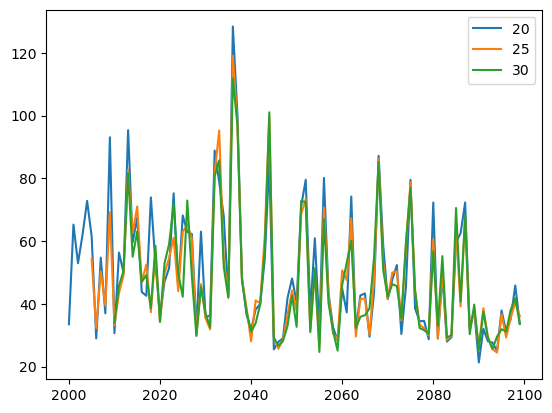

In [417]:
fig,ax = plt.subplots()
# Analyze evaluation results
for i,res in enumerate(results):
    evaluation_df = pd.DataFrame(res, columns=['year', 'mse', 'r2_score'])
    ax.plot(evaluation_df.year, np.sqrt(evaluation_df.mse), label = Ns[i])
ax.legend()
#ax.set_ylim(1,-1)
plt.show()
    

,0,1,2,3,4,5,6,7,8,9,10
1980,NaN,NaN,NaN,NaN,0.000000,256.627319,0.00000,225.346573,NaN,NaN,NaN
1981,NaN,NaN,NaN,NaN,11.629288,334.978149,4.49696,180.083740,NaN,NaN,NaN
1982,NaN,NaN,NaN,NaN,0.000000,301.703156,0.00000,170.826248,NaN,NaN,NaN
1983,NaN,NaN,NaN,NaN,127.097549,307.731262,0.00000,212.990540,NaN,NaN,NaN
1984,NaN,NaN,NaN,NaN,0.000000,302.973541,0.00000,159.205368,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2095,NaN,NaN,NaN,NaN,0.000000,309.103912,0.00000,5.390860,NaN,NaN,NaN
2096,NaN,NaN,NaN,NaN,0.000000,249.263641,0.00000,30.521137,NaN,NaN,NaN
2097,NaN,NaN,NaN,NaN,0.000000,245.197006,0.00000,15.897942,NaN,NaN,NaN
2098,NaN,NaN,NaN,NaN,0.000000,252.850571,0.00000,192.493622,NaN,NaN,NaN


Dorothy Hall -- MODIS fSCA possibly in the future?
Multitemporal snow cover mapping in mountainous terrain for Landsat climate data record development
Chris Crawford
Karl Rittger (past w/ observations we have)